### Importing Modules (p 544)

In [1]:
import pymc3 as mc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula as smf
import seaborn as sns

%matplotlib inline

### Introduction to Bayesian Statiscis (p 545)

### Model Definition (p 548)

In [2]:
# define the fixed model parameters
mu, sigma = 4.0, 2.0

# create an instance of mc.Model to represent the model
model = mc.Model()

In [3]:
# attach random variables to the model
with model:
    mc.Normal('X', mu, tau=1/sigma**2)

In [4]:
# inspect which random variables exist in a model
model.vars

[X]

In [5]:
# provide a starting point
start = dict(X=2)

with model:
    # pass a step class instance that implements an MCMC step
    step = mc.Metropolis()
    # sample from the random variables in the model
    trace = mc.sample(10000, start=start, step=step)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [X]
Sampling 4 chains, 0 divergences: 100%|██████████| 42000/42000 [00:04<00:00, 8812.25draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [6]:
# access the samples
X = trace.get_values("X")

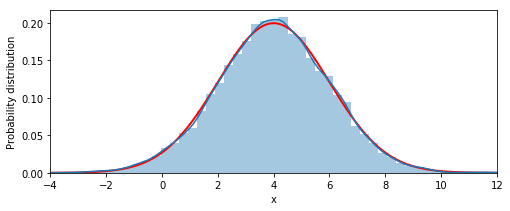

In [7]:
# compare PDF of the normal distributin and the sampled random variable
x = np.linspace(-4, 12, 1000)
y = stats.norm(mu, sigma).pdf(x)
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel('x')
ax.set_ylabel("Probability distribution");

In [8]:
# create dependent random variable X
model = mc.Model()
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, sd=sigma)

In [9]:
# inspect which random variables of a model
model.vars

[mean, sigma_log__, X]

In [10]:
# find the point in the parameter space that corresponds
# to the maximum of the posterior distribution
with model:
    start = mc.find_MAP()
start

logp = -2.1562, ||grad|| = 1.6366: 100%|██████████| 8/8 [00:00<00:00, 2531.07it/s]


{'mean': array(3.),
 'sigma_log__': array(-674.07720733),
 'X': array(3.),
 'sigma': array(1.78644019e-293)}

In [11]:
# sample from the random variables in the model
with model:
    step = mc.Metropolis()
    trace = mc.sample(100000, start=start, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [X]
>Metropolis: [sigma]
>Metropolis: [mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 402000/402000 [01:06<00:00, 6073.80draws/s]
/Users/geeyeol/.pyenv/versions/3.7.1/envs/python3-staging/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [12]:
# obtain the sample trace for the sigma variable
trace.get_values('sigma').mean()

1.7864401850541627e-293

In [13]:
# obtain the samples of X
X = trace.get_values('X')

# compute statistics
X.mean(), trace.get_values('X').std()

(3.0, 0.0)

#### Sampling Posterior Distributions (p 553)

#### Linear Regression (p 558)

### Summary (p 571)